Often times, it is natural to expect the trend of a time series to slows down over time. In that case, adding a damping factor $(\phi)$ to the forecasting method is advisable. This post shows how in some case adding a damping factor is more approriate.

The data to be used is US Industrial Production Index: Electric and Gas obtained from https://fred.stlouisfed.org

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse

In [98]:
df = pd.read_csv("dataset/IP-elec-gas.csv",index_col=0,parse_dates=True)
df = df.loc["1990-01-01":"2018-12-01"].copy()
df.columns = ['IP']
df.index.freq = "MS"
df.dropna(inplace=True)
print(df.head())
print(df.info())
print(df.index)

                 IP
DATE               
1990-01-01  84.6447
1990-02-01  77.4221
1990-03-01  73.4205
1990-04-01  67.4636
1990-05-01  66.0145
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 348 entries, 1990-01-01 to 2018-12-01
Freq: MS
Data columns (total 1 columns):
IP    348 non-null float64
dtypes: float64(1)
memory usage: 5.4 KB
None
DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='DATE', length=348, freq='MS')


From the plot, it is clear that the time series have a trend and seasonal components. Furthermore, the trend seems to be decreasing over time. Thus, this seems to be a good time to include damping.

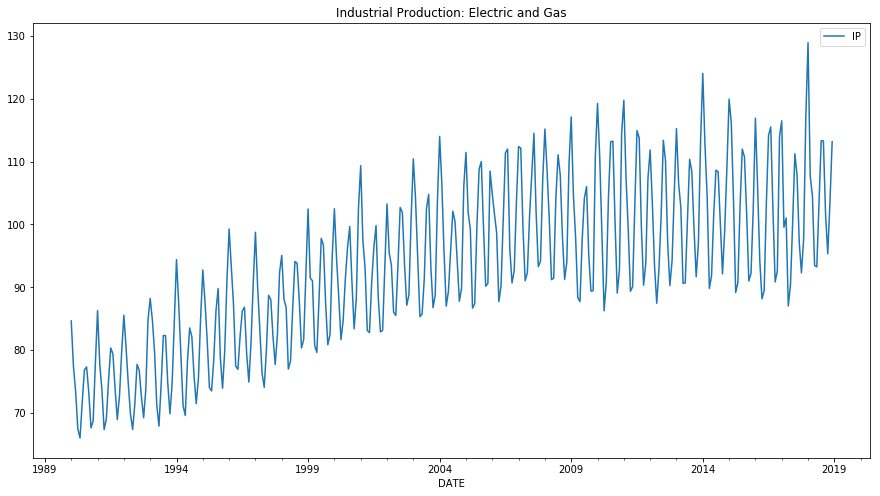

In [42]:
df.plot(figsize=(15,8), title = "Industrial Production: Electric and Gas")

The trend and seasonal components seems more additive than multiplicative. But usually it is advisable to try out both models (additive and multiplicative) and evaluate which model is more approriate.

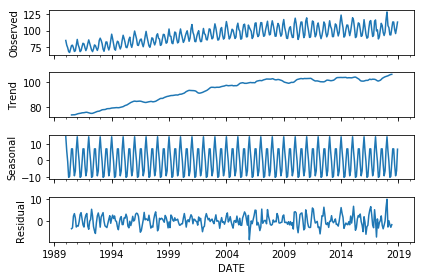

In [43]:
decompose = seasonal_decompose(df, model='add')
decompose.plot();

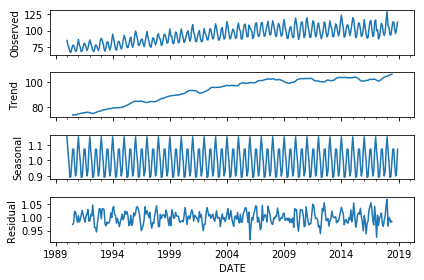

In [44]:
decompose2 = seasonal_decompose(df, model='mul')
decompose2.plot();

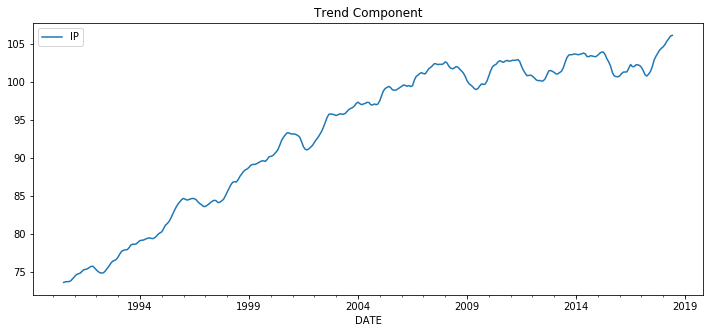

In [45]:
decompose.trend.plot(figsize=(12,5),title="Trend Component")

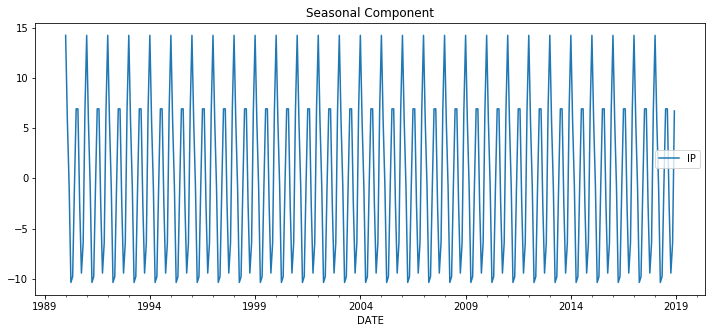

In [46]:
decompose.seasonal.plot(figsize=(12,5),title="Seasonal Component")

In [47]:
test_start = int(len(df)*0.2)
train = df.iloc[:-test_start].copy()
test = df.iloc[-test_start:].copy()

print(len(train))
print(len(test))

279
69


In [48]:
print(train.tail())
print(test.head())

                  IP
DATE                
2012-11-01   94.2111
2012-12-01  105.0203
2013-01-01  115.2323
2013-02-01  106.4512
2013-03-01  102.6701
                  IP
DATE                
2013-04-01   90.6136
2013-05-01   90.7000
2013-06-01  100.6631
2013-07-01  110.3583
2013-08-01  108.4228


# Holt-Winter

The first model is based on Holt-Winter method without damping $(\phi = 1)$. The smoothing factors will be optimized based on log-likelihood of the training set. The training set perform very well with relatively low RMSE and from the plot seems to fit quite well. The smoothing level $(\alpha = 0.51)$ suggest about equal weight between current and past level. Meanwhile, the smoothing slope $(\beta = 0)$ and seasonal $(\gamma = 0.25)$ have very low values which suggest more weights on the past values than the present.

In [104]:
model = ExponentialSmoothing(train['IP'],trend='add',seasonal='add',seasonal_periods=12,damped=False)
model = model.fit(optimized=True)
train["HW"] = model.fittedvalues.values

train.head()

,IP,HW,HWD
DATE,,,
1990-01-01,84.6447,84.675452,84.553866
1990-02-01,77.4221,77.738759,77.963161
1990-03-01,73.4205,72.458630,72.797356
1990-04-01,67.4636,66.367688,66.764547
1990-05-01,66.0145,66.137616,66.528316


In [105]:
train_hw_rmse = rmse(train["IP"],train["HW"])

model_level = model.params['smoothing_level']
model_slope = model.params['smoothing_slope']
model_seasonal = model.params['smoothing_seasonal']

print(f"Smoothing Level: {model_level:.2f}")
print(f"Smoothing Slope: {model_slope:.2f}")
print(f"Smoothing Seasonal: {model_seasonal:.2f}")
print(f"Training set RMSE: {train_hw_rmse:.2f}")

Smoothing Level: 0.51
Smoothing Slope: 0.00
Smoothing Seasonal: 0.25
Training set RMSE: 2.42


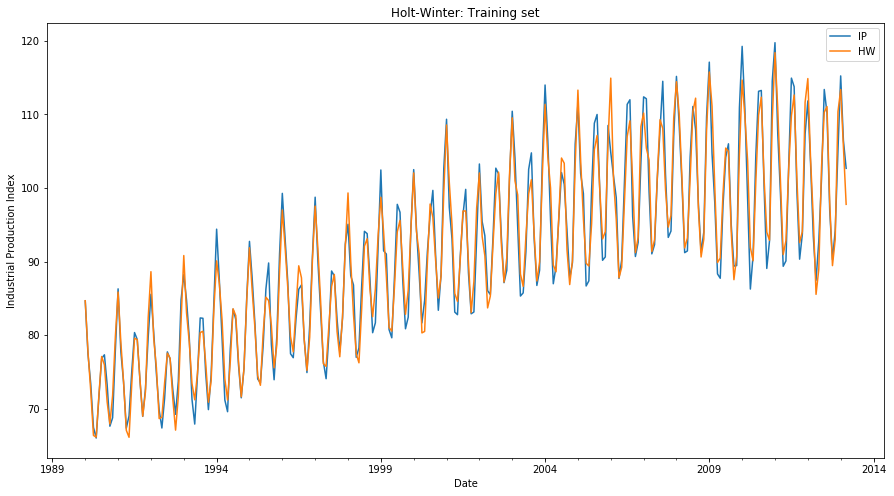

In [106]:
ax = train[['IP',"HW"]].plot(figsize=(15,8),title="Holt-Winter: Training set")
ax.set(xlabel='Date',ylabel='Industrial Production Index');

In [107]:
start = len(train)
end = start + len(test) - 1
test["HW"] = model.predict(start,end)

test_hw_rmse = rmse(test["IP"],test["HW"])

print(f"Test set RMSE: {test_hw_rmse:.2f}")

Test set RMSE: 6.36


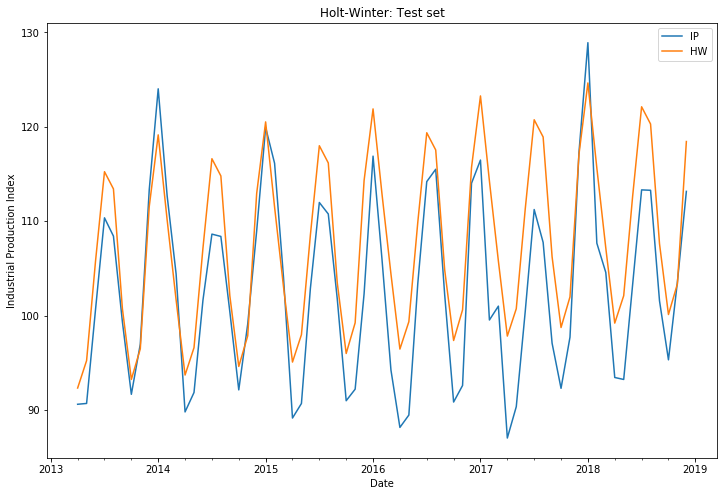

In [108]:
ax = test[["IP","HW"]].plot(figsize=(12,8),title="Holt-Winter: Test set")
ax.set(xlabel='Date',ylabel='Industrial Production Index');

The test set perform pretty decent but the prediction by Holt-Winter seems to have an upward bias (the actual and prediction values diverge). This is expected because there's no damping factor.

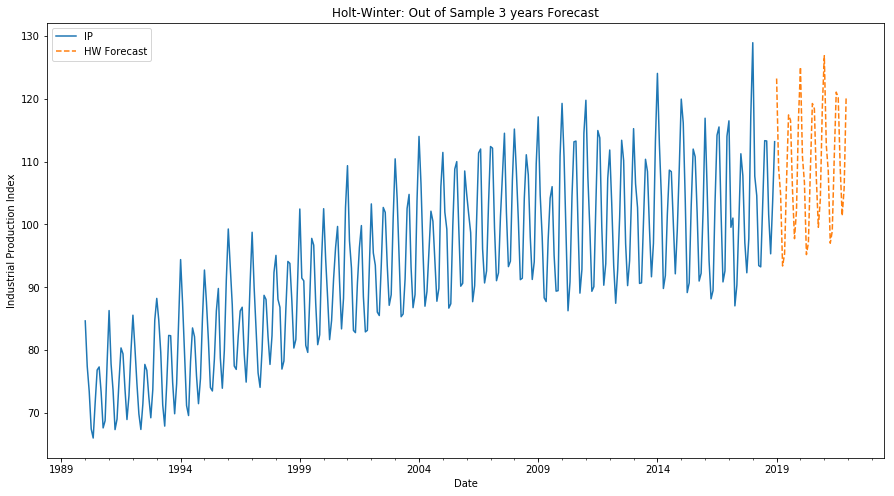

In [110]:
# out of sample forecasting
model = ExponentialSmoothing(df['IP'],trend='add',seasonal='add',seasonal_periods=12,damped=False)
model = model.fit(smoothing_level=model_level,smoothing_slope=model_slope,smoothing_seasonal=model_seasonal,optimized=False)
hw_fcast = model.predict(end+1, end+36)

ax = df['IP'].plot(figsize=(15,8),title="Holt-Winter: Out of Sample 3 years Forecast")
hw_fcast.plot(label="HW Forecast", linestyle="--")
ax.set(xlabel='Date',ylabel='Industrial Production Index')
plt.legend();

A three years (36 months) out of sample forecasting is done. Again, the Hot-Winter prediction seems to have an upward bias which may not be right because the trend seems to be more flat.

# Holt-Winter With Damping

Next, a damping factor, $\phi = 0.9$ is included. More damping means $\phi\to 0$ and less damping means $\phi\to 1$. No damping means $\phi = 1$ while $\phi > 1$ means amplify.

In [119]:
# damping -> 0 more damping. damping --> 1 less damping. damping > 1 amplify
model2 = ExponentialSmoothing(train['IP'],trend='add',seasonal='add',seasonal_periods=12,damped=True)
model2 = model2.fit(damping_slope=0.9,optimized=True)
train["HWD"] = model2.fittedvalues.values

train.head()

,IP,HW,HWD
DATE,,,
1990-01-01,84.6447,84.675452,84.553866
1990-02-01,77.4221,77.738759,77.963161
1990-03-01,73.4205,72.458630,72.797356
1990-04-01,67.4636,66.367688,66.764547
1990-05-01,66.0145,66.137616,66.528316


In [120]:
train_hwd_rmse = rmse(train["IP"],train["HWD"])

model2_level = model2.params['smoothing_level']
model2_slope = model2.params['smoothing_slope']
model2_seasonal = model2.params['smoothing_seasonal']
model2_damping = model2.params['damping_slope']

print(f"Smoothing Level: {model2_level:.2f}")
print(f"Smoothing Slope: {model2_slope:.2f}")
print(f"Smoothing Seasonal: {model2_seasonal:.2f}")
print(f"Damping Slope: {model2_damping:.2f}")
print(f"Training set RMSE: {train_hwd_rmse:.2f}")

Smoothing Level: 0.53
Smoothing Slope: 0.00
Smoothing Seasonal: 0.25
Damping Slope: 0.90
Training set RMSE: 2.43


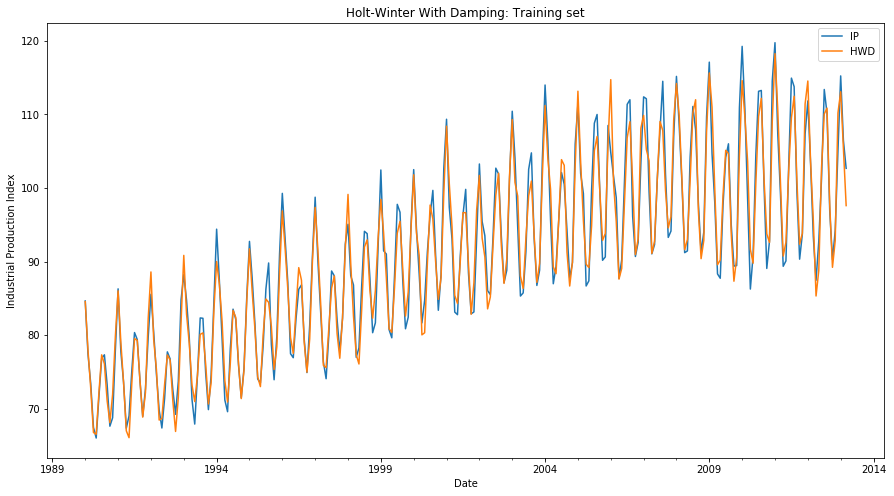

In [121]:
ax = train[['IP',"HWD"]].plot(figsize=(15,8),title="Holt-Winter With Damping: Training set")
ax.set(xlabel='Date',ylabel='Industrial Production Index');

In [122]:
test["HWD"] = model2.predict(start,end)

test_hwd_rmse = rmse(test["IP"],test["HWD"])

print(f"Test set RMSE: {test_hwd_rmse:.2f}")

Test set RMSE: 3.99


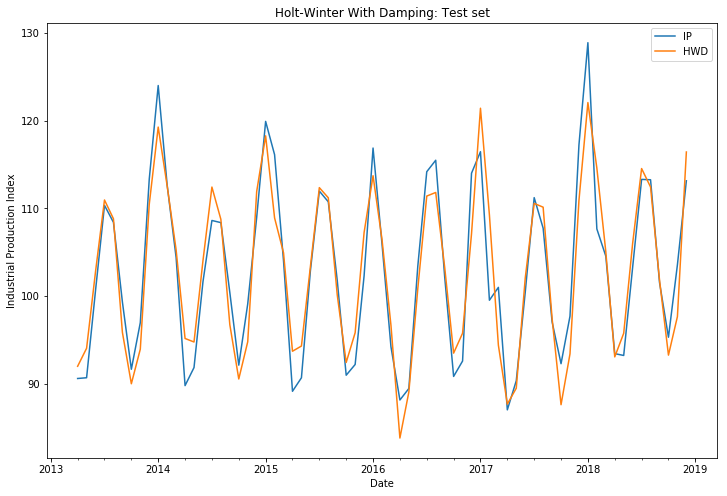

In [116]:
ax = test[["IP","HWD"]].plot(figsize=(12,8),title="Holt-Winter With Damping: Test set")
ax.set(xlabel='Date',ylabel='Industrial Production Index');

The test set for Holt-Winter with damping perfrom better than without damping. There's no upward bias in the prediction and the RMSE is lower compared to without damping.

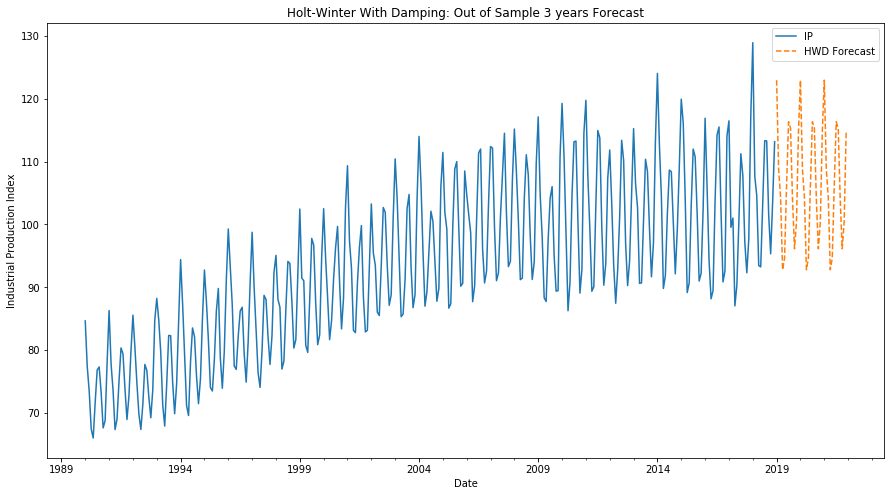

In [117]:
# out of sample forecasting
model2 = ExponentialSmoothing(df['IP'],trend='add',seasonal='add',seasonal_periods=12,damped=True)
model2 = model2.fit(smoothing_level=model2_level,smoothing_slope=model2_slope,smoothing_seasonal=model2_seasonal,
                    damping_slope=model2_damping,optimized=False)
hwd_fcast = model2.predict(end+1, end+36)

ax = df['IP'].plot(figsize=(15,8),title="Holt-Winter With Damping: Out of Sample 3 years Forecast")
hwd_fcast.plot(label="HWD Forecast",linestyle="--")
ax.set(xlabel='Date',ylabel='Industrial Production Index')
plt.legend();

The 3 years out of sample forecast too seems more right as it follows with the slowing down of the trend (flatter).

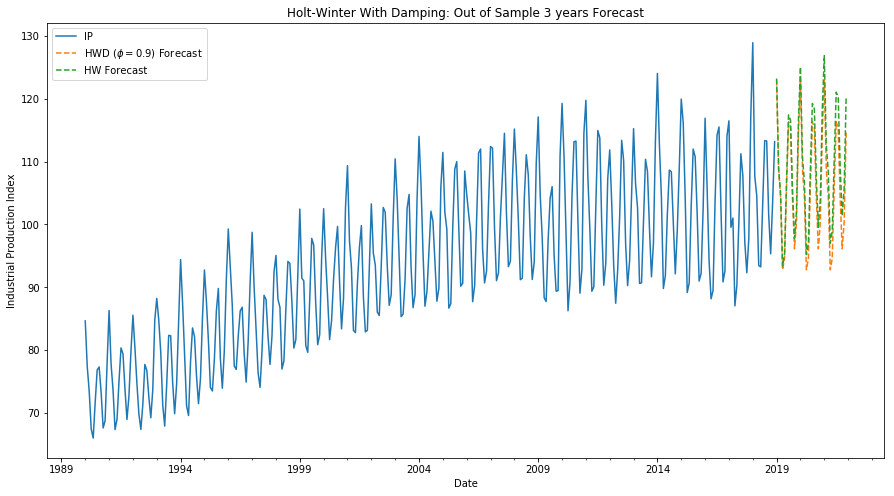

In [118]:
ax = df['IP'].plot(figsize=(15,8),title="Holt-Winter With Damping: Out of Sample 3 years Forecast")
hwd_fcast.plot(label="HWD ($\phi=0.9$) Forecast",linestyle="--")
hw_fcast.plot(label="HW Forecast",linestyle="--")
ax.set(xlabel='Date',ylabel='Industrial Production Index')
plt.legend();

For this time series, it seems to be more approriate to use Holt-Winter with damping. But, there is no gurantee that it will actually perform better in the actual future. However, if trend is expected to slow down including a damping factor is more approriate. If no expectation of slowing trend, there's no need to include damping factor.